# Projet 5 : Méthodes supervisées - Clean

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
from random import sample
from scipy import stats
import scipy.stats as st
from sklearn import linear_model, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from gensim import models, corpora
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle 

from gensim.models import phrases, Phrases, coherencemodel
import stop_words 
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import time
from time import time

from itertools import groupby
import operator

%matplotlib inline

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
sns.set(rc={'figure.figsize': (12, 8)})
sns.set(rc={'font.size': 15})

os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/05 - Projet 5/Main Project")

In [44]:
corpus = pd.read_csv('QueryResults.csv')
print(corpus.shape)
corpus.head()

(50000, 4)


,Body,Title,Score,Tags
0,<p>Does Visual Studio .NET have a way to toggl...,How can I toggle word wrap in Visual Studio?,221,<visual-studio><word-wrap>
1,<p><strong>When viewing a document</strong>: E...,NaN,460,NaN
2,<p>I lost my MySQL username and password. How ...,How do I retrieve my MySQL username and password?,132,<mysql>
3,<blockquote>\n <p>Stop the MySQL process.</p>...,NaN,167,NaN
4,<p>This should work </p>\n\n<pre><code>$root =...,NaN,140,NaN


# Pré-Traitement du texte

In [45]:
corpus = corpus.dropna()
Corpus = pd.DataFrame()
Corpus['Text'] = corpus['Body'] + corpus['Title']
Corpus['Tags'] = list(corpus['Tags'])

In [46]:
import stop_words
sw = stop_words.get_stop_words(language='en')
sw_new = ['will', 'want', 'use', 'like', 'need', 'hi', 'hello']
sw = sw + sw_new

In [47]:
Tokens = Corpus.Text.map(lambda text: word_tokenize(text))
Lemmatizer = WordNetLemmatizer()
Tokens = Tokens.map(lambda text: [Lemmatizer.lemmatize(w) for w in text])
import re
Tokens_clean =  Tokens.map(lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok))) \
                                                 if t.lower() not in sw and len(t)>1])

In [48]:
# Clean words that appear less than 5 times
from collections import Counter
frequency = Counter()
for text in Tokens_clean:
    frequency.update(set(text))
Tokens_clean = [[token for token in text if frequency[token] > 5] for text in Tokens_clean]

In [49]:
Corpus['Text'] = Tokens_clean

In [50]:
Corpus.head(10)

,Text,Tags
0,"[visual, studio, net, way, toggle, word, wrap,...",<visual-studio><word-wrap>
2,"[lost, mysql, username, password, retrieve, re...",<mysql>
5,"[script, drop, table, whose, name, begin, give...",<sql><sql-server><scripting><dynamic-sql>
7,"[firewall, behind, running, microsoft, server,...",<ruby><proxy><rubygems><ironruby>
10,"[font, programming, language, ide, href, http,...",<fonts><development-environment>
12,"[really, feel, learn, href, http, en, wikipedi...",<functional-programming><lisp>
13,"[really, understand, regular, expression, can,...",<regex>
14,"[developing, data, access, component, used, we...",<asp.net><configuration><asp-classic>
18,"[trying, strong, git, windows, strong, got, po...",<windows><git><cygwin><editor>
19,"[href, http, en, wikipedia, org, wiki, asp, ne...",<mysql><sql-server><tsql>


### Selection of the Top 1500 Tags

In [51]:
Corpus.Tags = Corpus.Tags.map(lambda text:
                                [w for w in text.replace('<','').replace('>',' ').replace('|','').split() if w])
Corpus.Tags = Corpus.Tags.map(lambda text:[Lemmatizer.lemmatize(w) for w in text])

new_list = [item for sublist in Corpus.Tags for item in sublist] 
freq = {key:len(list(group)) for key, group in groupby(np.sort(new_list))}
sorted_freq = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)
    
tags_N = []
freq_N = []
for i in range(1500):
    tags_N.append(sorted_freq[i][0])
    freq_N.append(sorted_freq[i][1])
    
df_1500 = pd.DataFrame([tags_N, freq_N])

df_1500.head()
Tags_1500 = df_1500.loc[0,:].tolist()

Corpus.Tags = Corpus.Tags.map(lambda text: [w for w in text if w in Tags_1500])

In [52]:
with open('Tags_1500', 'wb') as fid:
    pickle.dump(Tags_1500, fid,2)

In [53]:
Corpus = Corpus.reset_index(drop=True)
Corpus['Text'] = pd.Series(' '.join(w) for w in Corpus.Text)
Corpus.head()

,Text,Tags
0,visual studio net way toggle word wrap used fe...,"[visual-studio, word-wrap]"
1,lost mysql username password retrieve retrieve...,[mysql]
2,script drop table whose name begin given strin...,"[sql, sql-server, scripting, dynamic-sql]"
3,firewall behind running microsoft server mode ...,"[ruby, proxy, rubygems]"
4,font programming language ide href http www mi...,"[font, development-environment]"


## Train - Test Split

In [54]:
from sklearn.model_selection import train_test_split
Train, Test = train_test_split(Corpus, random_state = 42)

X_train = Train['Text']
X_test = Test['Text']

y_train = Train['Tags']
y_test = Test['Tags']

#### MultiLabelling of the output

In [55]:
mlb = preprocessing.MultiLabelBinarizer(classes=Tags_1500)
mlb.fit([item for item in y_train])

y_train_mlb = mlb.transform( [item for item in y_train])
y_test_mlb = mlb.transform([item for item in y_test])

print(y_test_mlb.shape)

(4312, 1500)


## Méthode d'évaluation de la métrique

In [56]:
def my_score(pred):
    # Une Note par Ligne : On calcule le nombre de 1 dans l'observation
    # Puis on calcul le nombre de matching de 1 entre obs et pred
    # Note = NB match / Nb_1_Obs
    Note_moy = 0 
    # Note finale = Sum(Note) / Nombre Lignes     (moyenne des notes sur les lignes)
    note = []
    # Nombre de tags réels total
    nb_tot = y_test_mlb.sum()
    # Boucle sur chaque résultat
    for i in range(len(y_test_mlb)):
        # Si le résultat réel a au moins un tag
        nb_res = y_test_mlb[i].sum()
        nb_tags = pred[i].sum()
        if (nb_res > 0):
            # Indice des tags réels
            res = np.argsort(i)[ :-(nb_res+1): -1]
            # Indice des (n_tags) meilleurs tags prédits
            res_pred = np.argsort(pred[i])[ :-(nb_tags+1): -1]
            # Rapport entre les deux
            note.append(len(np.intersect1d(res, res_pred)))

    Note_moy = np.round( np.sum(note) / y_test_mlb.shape[0], 3 )
    
    print('Ma note =', Note_moy)
    
    return Note_moy

In [95]:
def score_perso(pred): 
    Note = []
    Note_moy = 0
    Nb_tags_tot = y_test_mlb.sum()
    
    for i in range(len(y_test_mlb)):
        nb_tags_reel = y_test_mlb[i,:].sum()
        nb_tags_pred = pred[i,:].sum()
        
        bonne_pred = np.where([y_test_mlb[i], pred[i]])
        
        Note.append(bonne_pred)
        
    Note_moy = np.round(np.sum(Note)/ y_test_mlb.shape[0], 3)
    
    return Note, bonne_pred

### CountVectorizer

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,3), min_df = 5, max_df = 0.9)
vect.fit(X_train)
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

### TF-IDF Vectorizer

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df = 5, max_df = 0.9)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [60]:
with open('tfidf.pkl', 'wb') as fid:
    pickle.dump(tfidf, fid,2)

## Baseline model

#### Count Vectorizer

In [61]:
from sklearn.dummy import DummyClassifier
dummy_mf = DummyClassifier(strategy = 'most_frequent')
dummy_mf.fit(X_train_vect, y_train_mlb)
dummy_mf.score(X_test_vect, y_test_mlb)

0.0074211502782931356

In [62]:
pred_dummy = dummy_mf.predict(X_test_vect)
my_score(pred_dummy)

Ma note = 0.0


0.0

#### TfIdf

In [63]:
from sklearn.dummy import DummyClassifier
dummy_mf = DummyClassifier(strategy = 'most_frequent')
dummy_mf.fit(X_train_tfidf, y_train_mlb)
dummy_mf.score(X_test_tfidf, y_test_mlb)

0.0074211502782931356

In [64]:
from sklearn.dummy import DummyClassifier
dummy_mf = DummyClassifier()
dummy_mf.fit(X_train_vect, y_train_mlb)
dummy_mf.score(X_test_vect, y_test_mlb)

0.0011595547309833025

## Linear SVC

#### Using Count_vectorization

In [65]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC()
OvR_SVC = OneVsRestClassifier(LSVC)
OvR_SVC.fit(X_train_vect, y_train_mlb)
Pred_OvR_SVC = OvR_SVC.predict(X_test_vect)

print("The accuracy for this model is", OvR_SVC.score(X_test_vect, y_test_mlb))
print("The personalized score is", my_score(Pred_OvR_SVC))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.12036178107606679
Ma note = 0.091
The personalized score is 0.091


In [96]:
score_perso(Pred_OvR_SVC)

ValueError: operands could not be broadcast together with shapes (7,) (3,) 

#### Using Tf-Idf

In [66]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC()
OvR_SVC2 = OneVsRestClassifier(LSVC)
OvR_SVC2.fit(X_train_tfidf, y_train_mlb)
Pred_OvR_SVC2 = OvR_SVC2.predict(X_test_tfidf)

print("The accuracy for this model is", OvR_SVC2.score(X_test_tfidf, y_test_mlb))
print("The personalized score is", my_score(Pred_OvR_SVC2))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.13079777365491652
Ma note = 0.079
The personalized score is 0.079


In [67]:
# Fonction pour avoir les tags selon un modèle
def get_tags(pred, ID): 
    tags = np.where(pred[ID], Tags_1500, '')
    tags = list(filter(None, list(set(tags))))
    return tags 

In [68]:
get_tags(Pred_OvR_SVC2, 300)

[]

## Random Forest

#### Using Count Vectorizer

In [69]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
OvR_RFC = OneVsRestClassifier(RFC)
OvR_RFC.fit(X_train_vect, y_train_mlb)
Pred_RFC = OvR_RFC.predict(X_test_vect)

print("The accuracy for this model is", OvR_RFC.score(X_test_vect, y_test_mlb))
print("The personalized score is", my_score(Pred_RFC))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.05820964749536178
Ma note = 0.07
The personalized score is 0.07


#### Using Tf-Idf

In [70]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
OvR_RFC2 = OneVsRestClassifier(RFC)
OvR_RFC2.fit(X_train_tfidf, y_train_mlb)
Pred_RFC2 = OvR_RFC.predict(X_test_tfidf)

print("The accuracy for this model is", OvR_RFC2.score(X_test_tfidf, y_test_mlb))
print("The personalized score is", my_score(Pred_RFC2))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.058673469387755105
Ma note = 0.0
The personalized score is 0.0


## SGD Classifier

#### Using Count Vectorizer

In [71]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(max_iter=5, tol=None, penalty = 'elasticnet')
OvR_SGD = OneVsRestClassifier(SGD)
OvR_SGD.fit(X_train_vect, y_train_mlb)
Pred_SGD = OvR_SGD.predict(X_test_vect)

print("The accuracy for this model is", OvR_SGD.score(X_test_vect, y_test_mlb))
print("The personalized score is", my_score(Pred_SGD))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.0663265306122449
Ma note = 0.122
The personalized score is 0.122


#### Using Tf-Idf

In [72]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(max_iter=5)
OvR_SGD2 = OneVsRestClassifier(SGD)
OvR_SGD2.fit(X_train_tfidf, y_train_mlb)
Pred_SGD2 = OvR_SGD2.predict(X_test_tfidf)

print("The accuracy for this model is", OvR_SGD2.score(X_test_tfidf, y_test_mlb))
print("The personalized score is", my_score(Pred_SGD2))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.1185064935064935
Ma note = 0.071
The personalized score is 0.071


## Logistic Regression

#### Using Count Vectorizer

In [73]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter = 500)
OvR_LR = OneVsRestClassifier(LR)
OvR_LR.fit(X_train_vect, y_train_mlb)
Pred_LR = OvR_LR.predict(X_test_vect)

print("The accuracy for this model is", OvR_LR.score(X_test_vect, y_test_mlb))
print("The personalized score is", my_score(Pred_LR))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.11410018552875696
Ma note = 0.082
The personalized score is 0.082


#### Using Tf-Idf

In [74]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
OvR_LR2 = OneVsRestClassifier(LR)
OvR_LR2.fit(X_train_tfidf, y_train_mlb)
Pred_LR2 = OvR_LR2.predict(X_test_tfidf)

print("The accuracy for this model is", OvR_LR2.score(X_test_tfidf, y_test_mlb))
print("The personalized score is", my_score(Pred_LR2))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


The accuracy for this model is 0.05774582560296846
Ma note = 0.056
The personalized score is 0.056


### Modèle Probabiliste

In [75]:
from sklearn.linear_model import SGDClassifier
SGD_prob = SGDClassifier(loss = 'modified_huber', max_iter = 1000, tol = 1e-4 )
OVR_SGD_prob = OneVsRestClassifier(SGD_prob)
OVR_SGD_prob.fit(X_train_tfidf, y_train_mlb)
Pred_SGD_prob = OVR_SGD_prob.predict(X_test_tfidf)
Prob = OVR_SGD_prob.predict_proba(X_test_tfidf)

print(OVR_SGD_prob.score(X_test_tfidf, y_test_mlb))

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))


0.12569573283858998


In [76]:
def get_tags_prob(Mat_Prob, ID, seuil = 0.5):
    index = [Prob[ID].tolist().index([i for i in Prob[ID] if i >  seuil][k])
             for k in range(len([j for j in Prob[ID] if j > seuil]))]

    tags = [Tags_1500[i] for i in index]
    
    return tags

In [77]:
Prob = OVR_SGD_prob.predict_proba(X_test_tfidf)

In [78]:
def get_tags_prob(Mat_Prob, ID, seuil = 0.5):
    index = [Prob[ID].tolist().index([i for i in Prob[ID] if i >  seuil][k])
             for k in range(len([j for j in Prob[ID] if j > seuil]))]

    tags = [Tags_1500[i] for i in index]
    
    return tags

In [79]:
get_tags_prob(Prob, 30, seuil = 0)

['javascript',
 'java',
 'c#',
 'python',
 'android',
 '.net',
 'c',
 'iphone',
 'django',
 'debugging',
 'exception',
 'logging',
 'console',
 'naming-conventions',
 'localization',
 'log4j',
 'apache-commons',
 'firebug',
 'argparse',
 'error-reporting',
 'glassfish']

#### Nombre de tags prédit en fonction du seuil sur un example

In [88]:
seuil = []
nb_tags_pred = []
for i in range(10): 
    seuil.append(0.1*i)
    nb_tags_pred.append( len(get_tags_prob(Prob, 30, seuil = i/10)) )
    
print(seuil)
print(nb_tags_pred)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]
[21, 5, 3, 3, 2, 2, 0, 0, 0, 0]


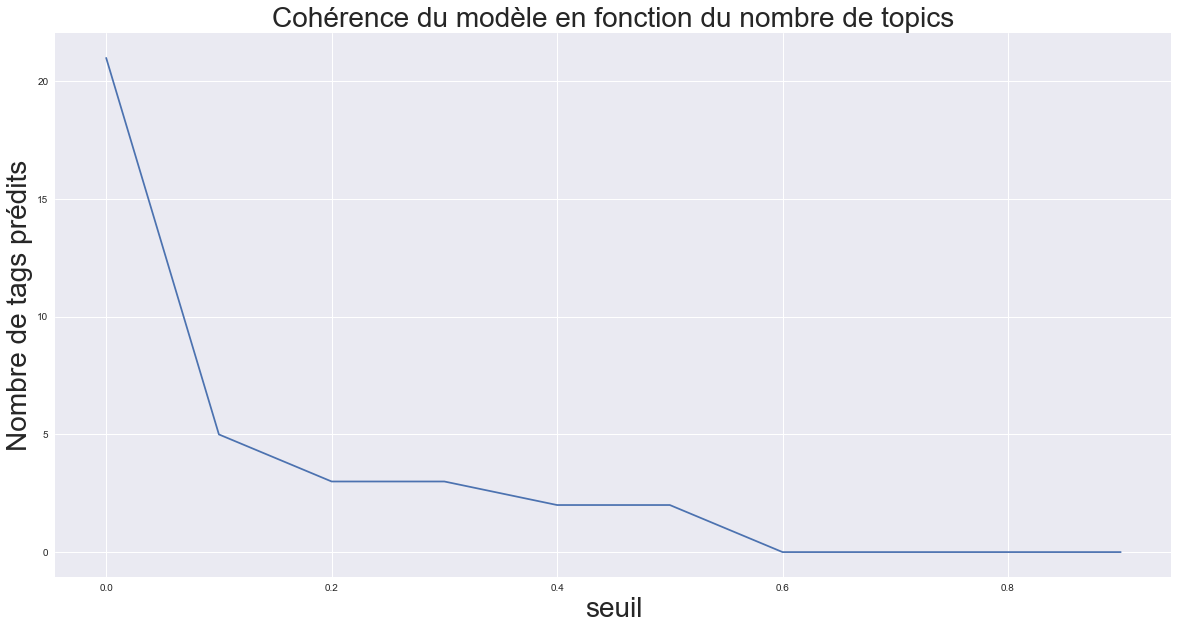

In [89]:
seuil = seuil
plt.figure(figsize=(20,10))
plt.title("Cohérence du modèle en fonction du nombre de topics", fontsize=28)
plt.plot(seuil, nb_tags_pred)
plt.xlabel("seuil", fontsize=28)
plt.ylabel("Nombre de tags prédits", fontsize=28)

plt.show()


## Modèle Final 

Les paramètres sont optimisés grâce à un GridSearchCV juste après dans le notebook 
(Cela est placé en fin de notebook car ce sont des étapes longues qu'on ne souhaite pas relancer à chaque fois)

In [ ]:
from sklearn.svm import LinearSVC
Best_LSVC = LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)

Best_SVC = OneVsRestClassifier(Best_LSVC)
Best_SVC.fit(X_train_tfidf, y_train_mlb)
Pred_Best_SVC = Best_SVC2.predict(X_test_tfidf)

print("The accuracy for this model is", Best_SVC.score(X_test_tfidf, y_test_mlb))
print("The personalized score is", my_score(Pred_Best_SVC))

In [ ]:
print(metrics.classification_report(Pred_Best_SVC, y_test_mlb))

In [ ]:
with open('modele_SVC.pkl', 'wb') as fid:
    pickle.dump(Best_SVC2, fid,2)

### Retrouver Tags

In [ ]:
def get_tags(pred): 
    tags = np.where(pred, Tags_1500, '').tolist()
    tags = np.unique(tags)
    tags = np.delete(tags, 0)
    #tags_set = set(tags)
    #tags = list(filter(None, list(set(tags))))
    return tags 

In [ ]:
pred = Best_SVC2.predict(res_tfidf)
get_tags(pred)

# Grid Search

## LSCV

In [90]:
pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC()))])
parameters = {
#    "clf__estimator__penalty": ['l1','l2'],
    "clf__estimator__loss": ['hinge','squared_hinge'],
#    "clf__estimator__dual": [True,False],
    "clf__estimator__tol": [.000001,.00001,.0001],
    "clf__estimator__C": [0.1,1,10,100, 1000],    
    "clf__estimator__max_iter": [10, 100, 200, 1000],    
}

model_tunning = GridSearchCV(pipeline, parameters, cv=3, scoring='accuracy')
model_tunning.fit(X_train_tfidf, y_train_mlb)

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1489 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1489 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1489 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1489 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1489 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1489 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1273 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1310 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1375 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1380 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1311 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1334 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1342 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1355 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1370 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1373 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1399 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1406 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1411 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1412 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1436 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1440 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1464 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1486 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1454 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1477 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 945 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1049 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1100 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 667 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1109 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1147 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1148 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1196 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserW

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1190 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1207 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1236 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1276 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1281 is present in all training examples.
  str(classes[c]))
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\multiclass.py:76: User

KeyboardInterrupt: 

In [ ]:
Pred_Best_LSVC = model_tunning.best_estimator_.predict(X_test_tfidf
print ("Accuracy Score: ", accuracy_score(y_test_mlb,Pred_Best_LSVC)))
model_tunning.best_estimator_

In [ ]:
print("The personalized score is", my_score(Pred_Best_LSVC))

## SGD

In [ ]:
pipeline = Pipeline([('clf', OneVsRestClassifier(SGDClassifier(eta0 = 0.1)))])
parameters = {
    "clf__estimator__penalty": ['l1','l2', 'elasticnet'],
#    "clf__estimator__loss": ['hinge','squared_hinge'],
#    "clf__estimator__dual": [True,False],
#    "clf__estimator__tol": [.000001,.00001,.0001],
#    "clf__estimator__C": [0.1,1,10,100],    
#    "clf__estimator__max_iter": [10, 100, 200, 1000], 
    "clf__estimator__verbose": [.001, .01, .1],
#    "clf__estimator__learning_rate": ['constant' , 'optimal', 'invscaling']
}

model_tunning = GridSearchCV(pipeline, parameters, cv=3, scoring='accuracy')
model_tunning.fit(X_train_tfidf, y_train_mlb)

In [ ]:
print ("Accuracy Score: ", accuracy_score(y_test_mlb, model_tunning.best_estimator_.predict(X_test_tfidf)))
model_tunning.best_estimator_

Pipeline(memory=None, steps=[('clf', OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None, n_jobs=1, penalty='l1', power_t=0.5, random_state=None, shuffle=True, tol=1e-06, verbose=0.1, warm_start=False), n_jobs=1))]